# Project 1: Digit Classification with KNN and Naive Bayes

Tim Spittle  
W207 - Applied Machine Learning  
Profossor: Alex Iliev  
Date: February 11, 2019

## Objective
In this project, I will implement an image recognition system for classifying digits from the open MNIST dataset.  

## Python Preparation

In [290]:
%matplotlib inline

# Import libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# DEPRECATED from sklearn.datasets import fetch_mldata
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
# DEPRECATED from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import math
import pandas

## Data Preparation
Below I will load the data and split into training, development, and test datasets. I will also create a "mini" subset of the training data in order to expedite experiments run in development of the model.

In [291]:
# Set the randomizer seed so results are the same each time
np.random.seed(0)

# Load the digit data from data_home
# DEPRECATED - mnist = fetch_mldata("MNIST original", data_home= "~/datasets/mnist")
mnist = fetch_openml('mnist_784', version=1, data_home='~/datasets/mnist')

# Rescale grayscale values to [0:1]
mnist_data_scale = mnist.data / 255.0

# Shuffle the inputs 
# Create a random permutation of the integers between 0 and the number of data points
shuffle = np.random.permutation(np.arange(mnist_data_scale.shape[0]))
# Apply the same permutation to data and labels to keep alignment
mnist_data_scale_shuffle =  mnist_data_scale[shuffle] 
mnist_target_shuffle = mnist.target[shuffle]

# Divide data between: test, dev, and training data (manual split)
test_data, test_labels = mnist_data_scale_shuffle[61000:], mnist_target_shuffle[61000:]
dev_data, dev_labels = mnist_data_scale_shuffle[60000:61000], mnist_target_shuffle[60000:61000]
train_data, train_labels = mnist_data_scale_shuffle[:60000], mnist_target_shuffle[:60000]
mini_train_data, mini_train_labels = mnist_data_scale_shuffle[:1000], mnist_target_shuffle[:1000]

In [292]:
# Explore/verify dimensions
print("Full Data shape: ", mnist_data_scale_shuffle.shape, "Full Labels shape:", mnist_target_shuffle.shape)

print("test_data shape: ", test_data.shape, "test_labels shape:", test_labels.shape)

print("dev_data shape: ", dev_data.shape, "dev_labels shape:", dev_labels.shape)

print("train_data shape: ", train_data.shape, "train_labels shape:", train_labels.shape)

# NOTE - mini_train overlaps with train
print("mini_train_data shape: ", mini_train_data.shape, "mini_train_labels shape:", mini_train_labels.shape)

Full Data shape:  (70000, 784) Full Labels shape: (70000,)
test_data shape:  (9000, 784) test_labels shape: (9000,)
dev_data shape:  (1000, 784) dev_labels shape: (1000,)
train_data shape:  (60000, 784) train_labels shape: (60000,)
mini_train_data shape:  (1000, 784) mini_train_labels shape: (1000,)


## (Question 1) Create a 10x10 grid to visualize 10 examples of each digit

Python hints:
- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

In [293]:
def plot_example_digits(in_data, in_labels, num_examples):
    # Create a subplot (10 x num_examples)
    fig, axes = plt.subplots(nrows = 10, ncols = num_examples, figsize = (12,12), sharex = "col", sharey = "row")
    # Loop through all 10 digits
    for i in range(10):
        # Extract index from "num_examples" of i digit 
        digit_index_list = np.flatnonzero(in_labels == str(i))[0:num_examples]
        # Extract "num_examples" examples of i digit (using index)
        for j in range(num_examples):
            digit_index = digit_index_list[j]
            # Reshape pixels into 28x28 grid for plotting
            pixels = np.array(in_data[digit_index,], dtype = "float").reshape((28, 28))
            axes[i, j].imshow(pixels, cmap = "binary")

    plt.axis("off")
    plt.show

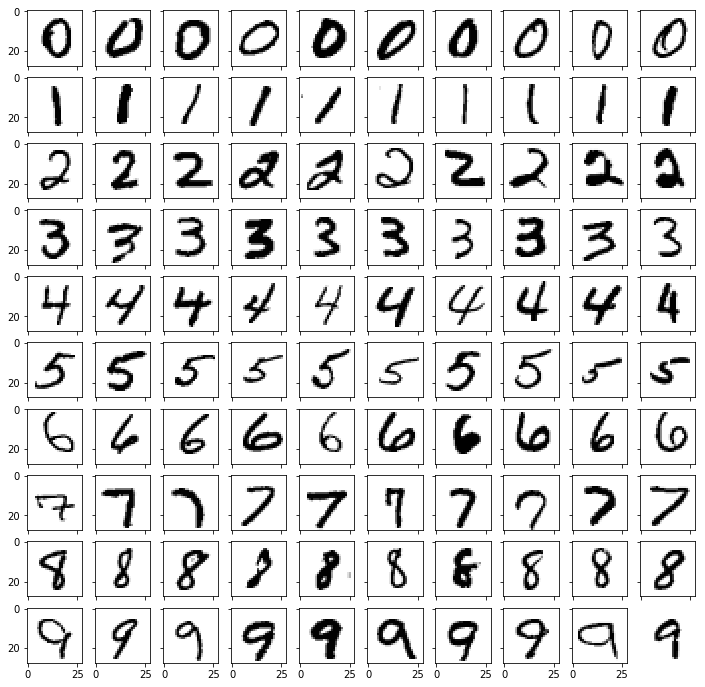

In [294]:
# Plot 10 examples
plot_example_digits(in_data = mini_train_data, in_labels = mini_train_labels, num_examples = 10)

## (Q2) Evaluate a K-Nearest-Neighbors model 
- Try each of k = [1,3,5,7,9] while using the mini training set.  
- Report accuracy on the dev set.  
- For k=1, show precision, recall, and F1 for each label.  

_**Question:** Which is the most difficult digit to classify?_

Python hints:
- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [295]:
def knn_custom(k_value, in_train_data, in_train_labels, in_test_data, in_test_labels):
    # Create KNN Model & fit with in_train_data + labels
    clf_model = KNeighborsClassifier(n_neighbors = k_value, weights = "distance")
    clf_model.fit(in_train_data, in_train_labels)
    # Use KNN model to predict labels for in_test_data
    result = clf_model.predict(in_test_data)
    # Calculate & print accuracy
    accuracy = accuracy_score(y_true = in_test_labels, y_pred = result)
    print("K = %3d ; Accuracy: %3.3f" %(k_value, accuracy))
    
    # Return prediction result
    return result

In [296]:
dev_pred_k1 = knn_custom(k_value = 1, 
                         in_train_data = mini_train_data,
                         in_train_labels = mini_train_labels,
                         in_test_data = dev_data,
                         in_test_labels = dev_labels)
dev_pred_k3 = knn_custom(k_value = 3, in_train_data = mini_train_data, in_train_labels = mini_train_labels,
                         in_test_data = dev_data, in_test_labels = dev_labels)
dev_pred_k5 = knn_custom(k_value = 5, in_train_data = mini_train_data, in_train_labels = mini_train_labels,
                         in_test_data = dev_data, in_test_labels = dev_labels)
dev_pred_k7 = knn_custom(k_value = 7, in_train_data = mini_train_data, in_train_labels = mini_train_labels,
                         in_test_data = dev_data, in_test_labels = dev_labels)
dev_pred_k9 = knn_custom(k_value = 9, in_train_data = mini_train_data, in_train_labels = mini_train_labels,
                         in_test_data = dev_data, in_test_labels = dev_labels)

K =   1 ; Accuracy: 0.884
K =   3 ; Accuracy: 0.882
K =   5 ; Accuracy: 0.883
K =   7 ; Accuracy: 0.880
K =   9 ; Accuracy: 0.875


In [297]:
print("K = 1 - Classification Report")
print(classification_report(y_true = dev_labels, y_pred = dev_pred_k1))

K = 1 - Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

   micro avg       0.88      0.88      0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



**ANSWER**: The most difficult digit to classify is 8, with an f1-score of 0.80, precision of 0.83, and recall of 0.77 (the lowest or second lowest values amongst all digits).

## (Q3) Using k=1, report dev set accuracy based on different training set sizes 
Also, measure the amount of time needed for prediction with each training size.

Python tips:
- time.time() gives a wall clock value you can use for timing operations

In [298]:
def test_accuracy_runtime(train_size, in_train_data, in_train_labels, in_test_data, in_test_labels):

    print("Train Size: %3.d" %(train_size))
    
    results_dict = {}
    start_time = time.time()
    # Trim training data according to train_size function parameter
    trim_train_data = in_train_data[:train_size]
    trim_train_labels = in_train_labels[:train_size]
    
    # Create KNN Model & fit with in_train_data + labels
    clf_model = KNeighborsClassifier(n_neighbors = 1, weights = "distance")
    clf_model.fit(trim_train_data, trim_train_labels)
    # Use KNN model to predict labels for in_test_data
    result = clf_model.predict(in_test_data)
    
    # Calculate & print accuracy & run time
    accuracy = accuracy_score(y_true = in_test_labels, y_pred = result)
    run_time = time.time() - start_time
    print("Accuracy: %3.3f ; Run Time: %3.3f seconds" %(accuracy, run_time))
    # Store and return accuracy and run_time
    results_dict["accuracy"] = accuracy
    results_dict["run_time"] = run_time
    
    print()
    return results_dict

In [299]:
# Test the following training set sizes
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
# Create lists to store accuracy and run time results for each loop
accuracy_results = []
run_time_results = []

# Loop through training set sizes
for train_test in train_sizes:
    # Call function
    result = test_accuracy_runtime(train_size = train_test,
                                  in_train_data = train_data, in_train_labels = train_labels,
                                  in_test_data = test_data, in_test_labels = test_labels)
    # Append lists to store accuracy and run time results
    accuracy_results.append(result["accuracy"])
    run_time_results.append(result["run_time"])

Train Size: 100
Accuracy: 0.696 ; Run Time: 1.211 seconds

Train Size: 200
Accuracy: 0.787 ; Run Time: 2.399 seconds

Train Size: 400
Accuracy: 0.828 ; Run Time: 4.833 seconds

Train Size: 800
Accuracy: 0.871 ; Run Time: 10.069 seconds

Train Size: 1600
Accuracy: 0.899 ; Run Time: 20.753 seconds

Train Size: 3200
Accuracy: 0.926 ; Run Time: 40.591 seconds

Train Size: 6400
Accuracy: 0.944 ; Run Time: 80.506 seconds

Train Size: 12800
Accuracy: 0.954 ; Run Time: 162.932 seconds

Train Size: 25000
Accuracy: 0.963 ; Run Time: 320.489 seconds



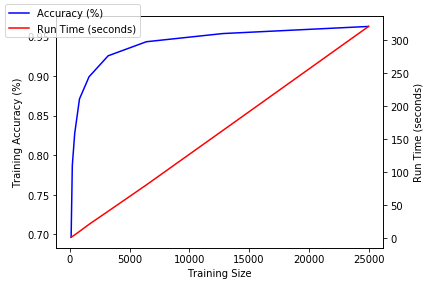

In [300]:
fig, ax1 = plt.subplots()
ax1.plot(train_sizes, accuracy_results, \
         label = "Accuracy (%)", color = "blue")
ax1.set_xlabel("Training Size")
ax1.set_ylabel("Training Accuracy (%)")

ax2 = ax1.twinx()
ax2.plot(train_sizes, run_time_results, \
         label = "Run Time (seconds)", color = "red")
ax2.set_ylabel("Run Time (seconds)")

fig.tight_layout()
fig.legend(loc = 2)
plt.show()

## (Q4) Fit a regression model that predicts accuracy from training size
_Questions:_  
- What does it predict for n=60000?  
- What's wrong with using regression here?  
- Can you apply a transformation that makes the predictions more reasonable?

Python tips:  
- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [301]:
def pred_accuracy_by_size(n, size_list, accuracy_list):

    # Convert lists to numpy.ndarrays (required format for fit())
    train_sizes_array = np.array(size_list).reshape(-1, 1)
    accuracy_list_array = np.array(accuracy_list).reshape(-1, 1)
    # Create and Fit Linear Regression Model
    lr_model = LinearRegression()
    lr_model.fit(train_sizes_array, accuracy_list)
    # Use model to predict based on n (function input parameter)
    result = lr_model.predict(np.array(n).reshape(-1,1))
    
    print("Predicted Accuracy (given training size of %3.d): %3.3f" %(n, result))

In [302]:
pred_accuracy_by_size(n = 60000, 
                      size_list = train_sizes, 
                      accuracy_list = accuracy_results)

Predicted Accuracy (given training size of 60000): 1.246


In [334]:
pred_accuracy_by_size(n = (1/60000), 
                      size_list = np.repeat(1,len(train_sizes))/train_sizes, 
                      accuracy_list = accuracy_results)

Predicted Accuracy (given training size of   0): 0.931


**ANSWER:** Predicted accuracy for non-transformed linear regression of accuracy on training size is 124.6%, which is, of course, impossible. The problem with this method is not only that accuracy cannot exceed 100%, but that the relationship between training size and accuracy does not appear to be linear (see figures above). The predicted variable in this case is approaching the ceiling of 100% but should never reach it - this is why transforming the predictor with a reciprocal term can give us a more accurate, though still not perfect, prediction.

## (Q5) Fit a 1-NN and output a confusion matrix for the dev data. 
Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

Python tips:
- confusion_matrix() produces a confusion matrix

In [304]:
def confusion_plot(confusion_matrix, target_names):
    
    # Plot confusion matrix (via imshow)
    plt.imshow(confusion_matrix, interpolation = "nearest", cmap = plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    # Loop through each value of the matrix to add data labels
    width, height = confusion_matrix.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_matrix[x][y]), xy = (y, x), 
                        horizontalalignment = "center",
                        verticalalignment = "center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

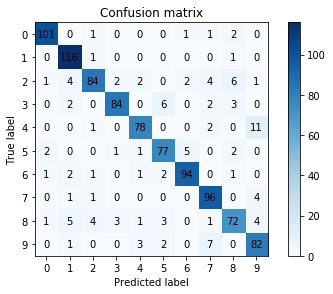

In [305]:
confusion_plot(confusion_matrix = confusion_matrix(y_true = dev_labels, 
                                                   y_pred = dev_pred_k1), 
               target_names = np.arange(0, 10, 1))

<function matplotlib.pyplot.show(*args, **kw)>

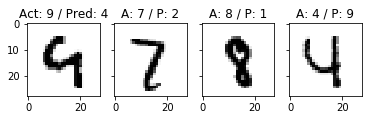

In [306]:
# Plot a few example mistakes
dev_mistakes = np.where(dev_labels != dev_pred_k1)
ex_mistake_1 = dev_mistakes[0][0]
ex_mistake_2 = dev_mistakes[0][1]
ex_mistake_3 = dev_mistakes[0][2]
ex_mistake_4 = dev_mistakes[0][3]

fig, axes = plt.subplots(nrows = 1, ncols = 4, sharex = "col", sharey = "row")

axes[0].imshow(dev_data[ex_mistake_1,].reshape((28,28)), cmap = "binary")
axes[1].imshow(dev_data[ex_mistake_2,].reshape((28,28)), cmap = "binary")
axes[2].imshow(dev_data[ex_mistake_3,].reshape((28,28)), cmap = "binary")
axes[3].imshow(dev_data[ex_mistake_4,].reshape((28,28)), cmap = "binary")

axes[0].set_title("Act: " + dev_labels[ex_mistake_1] + " / Pred: " + dev_pred_k1[ex_mistake_1])
axes[1].set_title("A: " + dev_labels[ex_mistake_2] + " / P: " + dev_pred_k1[ex_mistake_2])
axes[2].set_title("A: " + dev_labels[ex_mistake_3] + " / P: " + dev_pred_k1[ex_mistake_3])
axes[3].set_title("A: " + dev_labels[ex_mistake_4] + " / P: " + dev_pred_k1[ex_mistake_4])

plt.show

**ANSWER:** The most common mis-classifications were confusing 4's as 9's and 9's as 7's. This makes sense, as all three of these digits share a similar shape: long, mostly vertical line on the right hand side of the image and some horizontal lines toward the top. The examples plotted above further show the similarity between those particular digits.

## (Q6) Implement a simplified Gaussian blur by using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values
_NOTE: A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian - that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel._  

Try applying your blur filter in 3 ways:
- preprocess the **training data** but not the dev data
- preprocess the **dev data** but not the training data
- preprocess **both training and dev data**

Python tips:
    
Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [307]:
def gaussian_blur(in_data, std_dev):
    
    # Calculate Gaussian weights
    pixel_weights = np.zeros((3,3), dtype = "float")
    for r in range(3):
        for c in range(3):
            x_index = r-1
            y_index = c-1
            weight = (1 / (2 * math.pi * std_dev**2))**((y_index**2 + x_index**2) / (2 * std_dev**2))
            pixel_weights[r, c] = weight

    # Rebuild the dataset (i.e. don't overwrite - will improperly influence blur)
    blurred_train_data = np.zeros(in_data.shape)
    
    # Loop through each pixel in the training data
    for pixel_index in range(len(in_data)):
        pixels = np.array(in_data[pixel_index,], dtype = "float").reshape((28, 28))

        # Empty array to collect blurred pixels
        blurred_pixels_array = np.zeros(pixels.shape)
        # Loop through each object in the pixel array
        for i in range(28):
            for j in range(28):
                # Calculate offset (i.e. if on edges need to trim arrays)
                if i == 0:
                    if j == 0: # Top Left Corner
                        pixel_adj = pixels[:2, :2]
                        weights_adj = pixel_weights[:2, :2]
                    elif j == 27: # Top Right Corner
                        pixel_adj = pixels[:2, 26:]
                        weights_adj = pixel_weights[:2, 1:]
                    else: # Top Row Centered
                        pixel_adj = pixels[:2, j-1:j+2]
                        weights_adj = pixel_weights[:2]
                elif i == 27:
                    if j == 0: # Bottom Left Corner
                        pixel_adj = pixels[26:, :2]
                        weights_adj = pixel_weights[1:,:2]
                    elif j == 27: # Bottom Right Corner
                        pixel_adj = pixels[26:, 26:]
                        weights_adj = pixel_weights[1:,1:]
                    else: # Bottom Row Center
                        pixel_adj = pixels[26:, j-1:j+2]
                        weights_adj = pixel_weights[1:]
                elif j == 0: # Left Side
                    pixel_adj = pixels[i-1:i+2, :2]
                    weights_adj = pixel_weights[0:3,:1]
                elif j == 27: # Right Side
                    pixel_adj = pixels[i-1:i+2, 26:]
                    weights_adj = pixel_weights[0:3,:1]
                else: # Centered
                    pixel_adj = pixels[i-1:i+2, j-1:j+2]
                    weights_adj = pixel_weights
                
                # Calculate weighted average of all neighbors
                multiplied_array = np.multiply(pixel_adj, weights_adj)
                average_neighbors = np.sum(multiplied_array) / np.sum(weights_adj)
                
                # Input average of neighbors into new "blur" array
                blurred_pixels_array[i, j] = average_neighbors
                
        # Store blurred pixels back in re-constructed training data
        blurred_train_data[pixel_index,] = blurred_pixels_array.reshape((1,-1))

    return blurred_train_data

In [308]:
# Blur the data
mini_train_data_blur = gaussian_blur(in_data = mini_train_data, std_dev = 1)
test_data_blur = gaussian_blur(in_data = test_data, std_dev = 1)
dev_data_blur = gaussian_blur(in_data = dev_data, std_dev = 1)

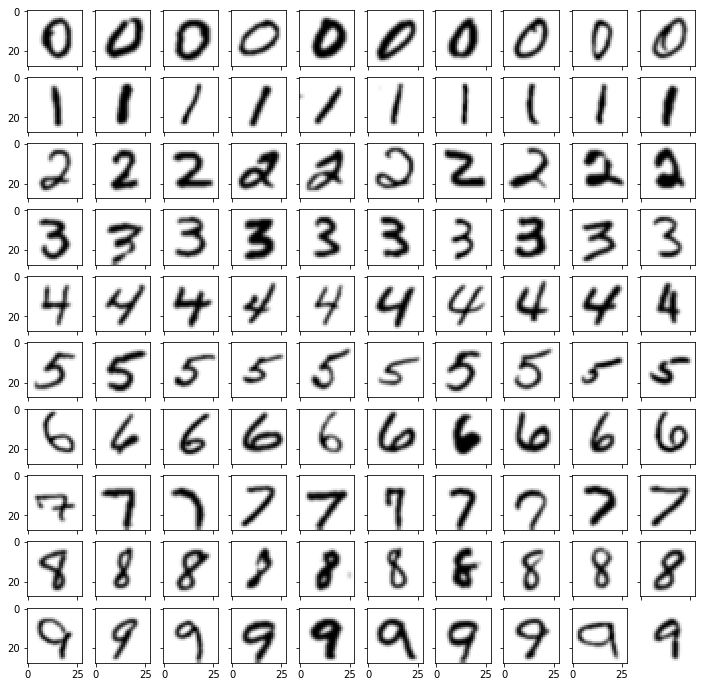

In [309]:
plot_example_digits(in_data = mini_train_data_blur, 
                    in_labels = mini_train_labels, 
                    num_examples = 10)

In [310]:
blur_k = 1

print("Raw Accuracy")
print("K = %3d ; Accuracy: %3.3f" %(blur_k, accuracy_score(y_true = dev_labels, y_pred = dev_pred_k1)))

# 6a - Preprocess the **training data** but not the dev data
print("Blurred: training")
blurred_train = knn_custom(k_value = blur_k, 
                           in_train_data = mini_train_data_blur, in_train_labels = mini_train_labels,
                           in_test_data = dev_data, in_test_labels = dev_labels)

# 6b - Preprocess the **dev data** but not the training data
print("Blurred: dev")
blurred_test = knn_custom(k_value = blur_k, 
                          in_train_data = mini_train_data, in_train_labels = mini_train_labels,
                          in_test_data = dev_data_blur, in_test_labels = dev_labels)

# 6c - Preprocess **both training and dev data**
print("Blurred: training + dev")
blurred_both = knn_custom(k_value = blur_k, 
                          in_train_data = mini_train_data_blur, in_train_labels = mini_train_labels,
                          in_test_data = dev_data_blur, in_test_labels = dev_labels)

Raw Accuracy
K =   1 ; Accuracy: 0.884
Blurred: training
K =   1 ; Accuracy: 0.906
Blurred: dev
K =   1 ; Accuracy: 0.872
Blurred: training + dev
K =   1 ; Accuracy: 0.903


**ANSWER:** Blurred training data alone or blurred data with accompanying blurred test data appear to be better at predicting digits than blurred test data alone and the original data alone as well. This makes intuitive sense as a blurred set of training data will likely be much more generalizable, and less prone to over-fitting, then the more rigid original data.

## (Q7) Fit a Naive Bayes classifier and report accuracy on the dev data
Remember that Naive Bayes estimates P(feature|label).  
- While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB.  
- Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB.  
- Does the multi-class version improve the results? Why or why not?

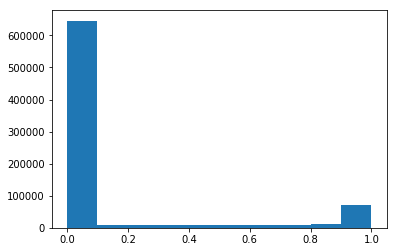

In [311]:
# Explore the distribution of pixel values to determine thresholds for binarizing/bucketing
mini_train_data_flat = mini_train_data.flatten()
plt.hist(mini_train_data_flat, bins = 10)
plt.show()

There are a substantial amount of 0 pixel values and still many more 1's than any values between 0 and 1.  

The method I will use to **binarize** will be to assign all values over 0.1 to 1. This will allow for more generalizable model fitting, as the sensitivity around such few 1 pixel values (compared to so many 0's) will be watered down.  

The method I will use to **bucket** will be to multiplyeach pixel value by 2 and round to the nearest integer. This will keep: 
- 0's and all values below 0.25 at 0 (white)
- 1's and all values above 0.75 will be assigned to 2 (black)
- The remaining (0.25:0.75) will be assigned to 1 (gray)  

Given the spread out distribution of pixel values this makes sense - the number line width of the gray bucket is larger than the white or black but should still contain less or comparable pixel obervations. 

In [312]:
def process_mnist(in_data):
    # Initialize a new feature array with the same shape as the original data.
    binarized_data = np.zeros(in_data.shape)
    rounded_data = np.zeros(in_data.shape)

    # Apply thresholds to each feature.
    for feature in range(in_data.shape[1]):
        binarized_data[:,feature] = in_data[:,feature] > 0.1
        rounded_data[:,feature] = np.round(in_data[:,feature] * 2)
        
    return binarized_data, rounded_data

In [313]:
# Create new binarized & rounded training and dev data
mini_train_data_processed = process_mnist(mini_train_data)
dev_data_processed = process_mnist(dev_data)

binarized_mini_train_data = mini_train_data_processed[0]
rounded_mini_train_data = mini_train_data_processed[1]

binarized_dev_data = dev_data_processed[0]
rounded_dev_data = dev_data_processed[1]

<function matplotlib.pyplot.show(*args, **kw)>

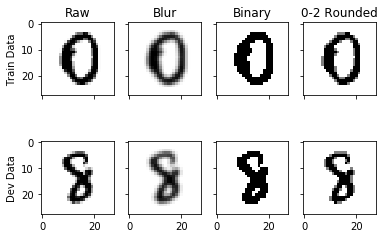

In [314]:
# Plot example digits
fig, axes = plt.subplots(nrows = 2, ncols = 4, sharex = "col", sharey = "row")

axes[0,0].imshow(mini_train_data[0,].reshape((28,28)), cmap = "binary")
axes[0,1].imshow(mini_train_data_blur[0,].reshape((28,28)), cmap = "binary")
axes[0,2].imshow(binarized_mini_train_data[0,].reshape((28,28)), cmap = "binary")
axes[0,3].imshow(rounded_mini_train_data[0,].reshape((28,28)), cmap = "binary")

axes[1,0].imshow(dev_data[0,].reshape((28,28)), cmap = "binary")
axes[1,1].imshow(dev_data_blur[0,].reshape((28,28)), cmap = "binary")
axes[1,2].imshow(binarized_dev_data[0,].reshape((28,28)), cmap = "binary")
axes[1,3].imshow(rounded_dev_data[0,].reshape((28,28)), cmap = "binary")

axes[0,0].set_title("Raw")
axes[0,1].set_title("Blur")
axes[0,2].set_title("Binary")
axes[0,3].set_title("0-2 Rounded")

axes[0,0].set_ylabel("Train Data")
axes[1,0].set_ylabel("Dev Data")

plt.show

In [335]:
bnb = BernoulliNB()
bnb.fit(binarized_mini_train_data, mini_train_labels)
dev_pred_bnb = bnb.predict(dev_data)
print(classification_report(dev_labels, dev_pred_bnb))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       106
           1       0.93      0.92      0.93       118
           2       0.78      0.72      0.75       106
           3       0.76      0.76      0.76        97
           4       0.76      0.82      0.79        92
           5       0.84      0.64      0.72        88
           6       0.89      0.88      0.89       102
           7       0.91      0.85      0.88       102
           8       0.63      0.82      0.71        94
           9       0.78      0.80      0.79        95

   micro avg       0.82      0.82      0.82      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.82      0.82      1000



In [336]:
mnb = MultinomialNB()
mnb.fit(rounded_mini_train_data, mini_train_labels)
dev_pred_mnb = mnb.predict(dev_data)
print(classification_report(dev_labels, dev_pred_mnb))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       106
           1       0.91      0.87      0.89       118
           2       0.78      0.75      0.76       106
           3       0.76      0.76      0.76        97
           4       0.76      0.80      0.78        92
           5       0.87      0.68      0.76        88
           6       0.90      0.89      0.90       102
           7       0.98      0.86      0.92       102
           8       0.58      0.76      0.66        94
           9       0.73      0.81      0.77        95

   micro avg       0.81      0.81      0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.83      0.81      0.82      1000



**ANSWER**: Multiclass Naive Bayes does not improve the result over Bernoulli Naive Bayes. This may be due to the fact that the data do not contain very many "gray" pixels: the majority are white and black. Given that Naive Bayes assumes independence among predictors (i.e. the nearest pixels have no effect on the likelihood of a particular pixel (predictor), given the class), the added gray values are likely not adding much predictive power. Intuitively, the likelihood that the exact pixel on two versions of the exact same digit are similar shades of gray in both cases is less likely than for them to overlap at all (i.e. the binary dataset). However, the accuracy is relatively close on both, so it is possible with more training data the multiclass NB may perform better.

## (Q8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model.  
- What is the best value for alpha? 
- What is the accuracy when alpha=0? 
- Is this what you'd expect?

_Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation._

In [326]:
alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

alpha_search = GridSearchCV(bnb, alphas)
alpha_search.fit(binarized_mini_train_data, mini_train_labels)
pandas.DataFrame(alpha_search.cv_results_)

C:\Users\manat\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\manat\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter wil

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.016290,0.002048,0.007647,0.001695,0,{'alpha': 0.0},0.833828,0.798193,0.797583,0.810,0.016990,6,0.892911,0.907186,0.902840,0.900979,0.005974
1,0.016576,0.002578,0.006001,0.000024,0.0001,{'alpha': 0.0001},0.842730,0.804217,0.818731,0.822,0.015917,1,0.882353,0.898204,0.892377,0.890978,0.006546
2,0.014628,0.001694,0.006986,0.002827,0.001,{'alpha': 0.001},0.842730,0.804217,0.818731,0.822,0.015917,1,0.879336,0.893713,0.889387,0.887479,0.006022
3,0.012633,0.000471,0.004323,0.000469,0.01,{'alpha': 0.01},0.851632,0.792169,0.815710,0.820,0.024504,3,0.868778,0.892216,0.887892,0.882962,0.010184
4,0.014144,0.001042,0.004813,0.000860,0.1,{'alpha': 0.1},0.845697,0.795181,0.818731,0.820,0.020678,3,0.864253,0.878743,0.877429,0.873475,0.006543
5,0.012584,0.000439,0.004016,0.000032,0.5,{'alpha': 0.5},0.836795,0.807229,0.812689,0.819,0.012880,5,0.856712,0.875749,0.872945,0.868468,0.008392
6,0.012310,0.001241,0.004978,0.000801,1,{'alpha': 1.0},0.821958,0.807229,0.800604,0.810,0.008942,6,0.852187,0.866766,0.866966,0.861973,0.006920
7,0.014331,0.001857,0.005268,0.000908,2,{'alpha': 2.0},0.833828,0.795181,0.791541,0.807,0.019184,8,0.853695,0.851796,0.855007,0.853500,0.001318
8,0.012966,0.000812,0.005650,0.000469,10,{'alpha': 10.0},0.810089,0.740964,0.761329,0.771,0.029076,9,0.794872,0.826347,0.808670,0.809963,0.012882


In [319]:
print("Best Value for alpha: ", alpha_search.best_params_["alpha"])
print("Accuracy when alpha = 0: ", alpha_search.cv_results_["mean_test_score"][0])

Best Value for alpha:  0.0001
Accuracy when alpha = 0:  0.81


**ANSWER**: Th optimal value for alpha of 0.0001 is roughly what I would expect. The alpha parameter for smoothing should represent a nominal value that, when added to the values, will smooth the distribution slightly without being large enough to distrort the values and weaken the predictive strength. This is especially true when considering datasets (such as this one) with many 0 values. Converseley, the alpha should not be so large that it distorts the data, as is the case with the larger alphas in the above table; as the alphas increase, the test scores decrease. When the maximum value of the predictor is 1, it would not make sense to have an alpha 10x that value and we see the result reflect this.

## (Q9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. 
You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [320]:
gnb = GaussianNB()
gnb.fit(mini_train_data, mini_train_labels)
dev_pred_gnb = gnb.predict(dev_data)
print(classification_report(dev_labels, dev_pred_gnb))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       106
           1       0.87      0.81      0.84       118
           2       0.59      0.44      0.51       106
           3       0.64      0.29      0.40        97
           4       0.78      0.32      0.45        92
           5       0.30      0.67      0.41        88
           6       0.74      0.85      0.79       102
           7       0.92      0.57      0.70       102
           8       0.38      0.11      0.17        94
           9       0.43      0.91      0.58        95

   micro avg       0.59      0.59      0.59      1000
   macro avg       0.64      0.58      0.57      1000
weighted avg       0.65      0.59      0.58      1000



In [321]:
gnb_2 = GaussianNB(var_smoothing = 0.1)
gnb_2.fit(mini_train_data, mini_train_labels)
dev_pred_gnb_2 = gnb_2.predict(dev_data)
print(classification_report(dev_labels, dev_pred_gnb_2))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       106
           1       0.82      0.96      0.89       118
           2       0.86      0.68      0.76       106
           3       0.82      0.77      0.79        97
           4       0.79      0.73      0.76        92
           5       0.81      0.73      0.77        88
           6       0.88      0.89      0.88       102
           7       0.99      0.86      0.92       102
           8       0.65      0.70      0.68        94
           9       0.67      0.87      0.76        95

   micro avg       0.82      0.82      0.82      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.83      0.82      0.82      1000



<function matplotlib.pyplot.show(*args, **kw)>

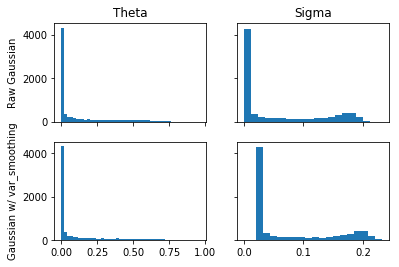

In [322]:
theta_flat = gnb.theta_.flatten()
sigma_flat = gnb.sigma_.flatten()
theta_flat_2 = gnb_2.theta_.flatten()
sigma_flat_2 = gnb_2.sigma_.flatten()

fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = "col", sharey = "row")

axes[0,0].hist(theta_flat, bins = "auto")
axes[0,1].hist(sigma_flat, bins = "auto")
axes[1,0].hist(theta_flat_2, bins = "auto")
axes[1,1].hist(sigma_flat_2, bins = "auto")

axes[0,0].set_title("Theta")
axes[0,1].set_title("Sigma")

axes[0,0].set_ylabel("Raw Gaussian")
axes[1,0].set_ylabel("Gaussian w/ var_smoothing")

plt.show

**ANSWER**: By adjusting the var_smoothing parameter (portion of the largest variance of all features that is added to variances for calculation stability) the sigma was shifted away from 0. The initial GaussianNB model had too many 0 sigma values and was therefore too narrow in scope and overly-sensitive.

### (Q10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. 
Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit.  
Because you're using a Bernoulli model, each pixel output will be either 0 or 1.  
How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

In [323]:
def generate_digits(bnb_model, num_examples):
    # Create a subplot
    fig, axes = plt.subplots(nrows = 10, ncols = num_examples, figsize = (12,12), sharex = "col", sharey = "row")
    # Loop through all 10 digits
    for i in range(10):
        # Generate "num_examples" examples of i digit (using index)
        for j in range(num_examples):
            random_digit = np.random.rand(784)
            random_digit_gen = np.array([a<b for a,b in zip(random_digit, np.exp(bnb_model.feature_log_prob_[i]))], dtype = "float")
            # Reshape pixels into 28x28 grid for plotting
            pixels = random_digit_gen.reshape((28, 28))
            axes[i, j].imshow(pixels, cmap = "binary")

    plt.axis("off")
    plt.show

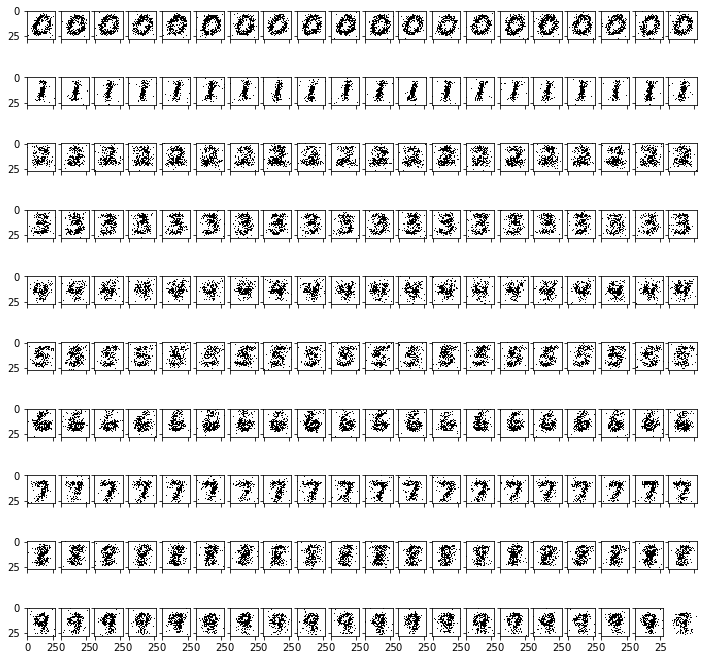

In [324]:
generate_digits(bnb_model = bnb, num_examples = 20)

**ANSWER**: The generated digits have a lot more noise than the training data. That is because, by generating the pixels probabilistically, noise from the training data will be reiterated. Take, for example, the few rouge pixels around the periphery of a lot of these generated digits: one or two sloppily written examples in the training data will allow for a small, but still impactful, probability for a given feature that isn't otherwise very predictive of the digit class.  
Compare these digits to the confusion matrix in Question 5: we can see some of the noise that the early models were having trouble classifying: 4's and 9's are especially noisy, which means we were less likely to be able to predict it before and have a more challenging time generating clean digits now.

## (Q11)  Calibration of Naive Bayes model
Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value.  
For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy.  
So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.
- _NOTE: I did not apply this correct/total counter method as suggested. Instead I simply extracted the class of the actual max posterior and ran a classification report against the original labels._

How would you characterize the calibration for the Naive Bayes model?

In [373]:
bnb_11 = BernoulliNB(alpha = 0.01)
bnb_11.fit(binarized_mini_train_data, mini_train_labels)
pred_proba = bnb_11.predict_proba(dev_data)
model_classes = bnb_11.classes_

dev_pred_bnb_11_val = np.empty(pred_proba.shape[0], dtype = "str")
dev_pred_bnb_11_prob = np.empty(pred_proba.shape[0], dtype = "float")

# Extract and store the class of maximum posterior probability
for i in range(len(dev_pred_bnb_11)):
    dev_pred_bnb_11_val[i] = str("".join(model_classes[pred_proba[i] == pred_proba[i].max()]))
    dev_pred_bnb_11_prob[i] = pred_proba[i].max()
    
# Classification report
print(classification_report(dev_labels, dev_pred_bnb_11_val))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       106
           1       0.94      0.88      0.91       118
           2       0.78      0.82      0.80       106
           3       0.74      0.75      0.75        97
           4       0.77      0.82      0.79        92
           5       0.82      0.68      0.75        88
           6       0.95      0.87      0.91       102
           7       0.94      0.85      0.89       102
           8       0.62      0.80      0.70        94
           9       0.77      0.79      0.78        95

   micro avg       0.82      0.82      0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.83      0.82      0.82      1000



<function matplotlib.pyplot.show(*args, **kw)>

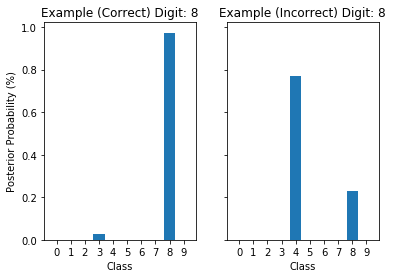

In [374]:
# Plot example digits
fig, axes = plt.subplots(nrows = 1, ncols = 2, sharex = "col", sharey = "row")

axes[0].bar(bnb_11.classes_, pred_proba[0])
axes[1].bar(bnb_11.classes_, pred_proba[10])

axes[0].set_title("Example (Correct) Digit: " + dev_labels[0])
axes[1].set_title("Example (Incorrect) Digit: " + dev_labels[10])

axes[0].set_ylabel("Posterior Probability (%)")
axes[0].set_xlabel("Class")
axes[1].set_xlabel("Class")

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

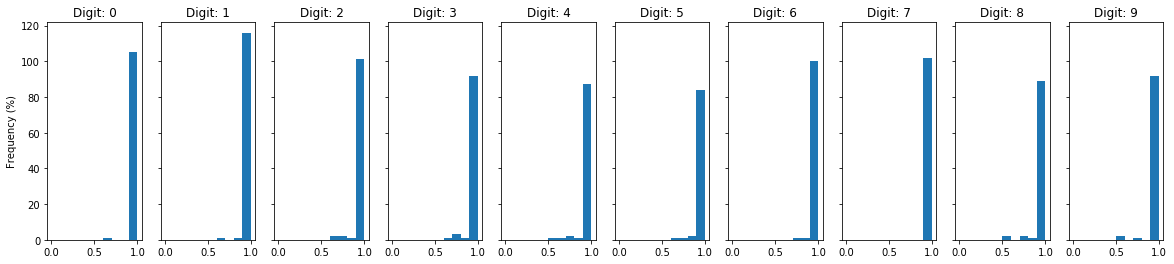

In [401]:
# plt.hist(dev_pred_bnb_11_prob[dev_labels == "0"])

# Plot example digits
fig, axes = plt.subplots(nrows = 1, ncols = 10, sharex = "col", sharey = "row")

fig.set_figwidth(20)

axes[0].hist(dev_pred_bnb_11_prob[dev_labels == "0"], bins = 10, range = (0,1))
axes[1].hist(dev_pred_bnb_11_prob[dev_labels == "1"], bins = 10, range = (0,1))
axes[2].hist(dev_pred_bnb_11_prob[dev_labels == "2"], bins = 10, range = (0,1))
axes[3].hist(dev_pred_bnb_11_prob[dev_labels == "3"], bins = 10, range = (0,1))
axes[4].hist(dev_pred_bnb_11_prob[dev_labels == "4"], bins = 10, range = (0,1))
axes[5].hist(dev_pred_bnb_11_prob[dev_labels == "5"], bins = 10, range = (0,1))
axes[6].hist(dev_pred_bnb_11_prob[dev_labels == "6"], bins = 10, range = (0,1))
axes[7].hist(dev_pred_bnb_11_prob[dev_labels == "7"], bins = 10, range = (0,1))
axes[8].hist(dev_pred_bnb_11_prob[dev_labels == "8"], bins = 10, range = (0,1))
axes[9].hist(dev_pred_bnb_11_prob[dev_labels == "9"], bins = 10, range = (0,1))

axes[0].set_title("Digit: 0")
axes[1].set_title("Digit: 1")
axes[2].set_title("Digit: 2")
axes[3].set_title("Digit: 3")
axes[4].set_title("Digit: 4")
axes[5].set_title("Digit: 5")
axes[6].set_title("Digit: 6")
axes[7].set_title("Digit: 7")
axes[8].set_title("Digit: 8")
axes[9].set_title("Digit: 9")

axes[0].set_ylabel("Frequency (%)")

plt.show

**ANSWER**: The accuracy of the Bernoulli Naive Bayes model is comparable to the previous models. 
- Digits 0, 1, 6, and 7 have accuracy above 90% and similiarly have a high clustering of posterior probabilities around 90-100%. 
- Digits 3, 4, 8, and 9 have lower relative accuracy (66-77%) and (slightly) lower posterior probabilities.
- Digit 5 has lower posterior probabilities but was still relatively accurate (82%, about the average)
- Conversely, digit 2 has higher posterior probabilities but was below average in accuracy (78%)  

Overall, the model appears to be well calibrated.